In [1]:
import pandas as pd
import urllib.request
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy import stats

url = "https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/parcours-data-scientist/P2/fr.openfoodfacts.org.products.csv.zip"
urllib.request.urlretrieve(url, "./fr.openfoodfacts.org.products.csv.zip")

('./fr.openfoodfacts.org.products.csv.zip',
 <http.client.HTTPMessage at 0x1d12c84ef00>)

In [2]:
with zipfile.ZipFile("./fr.openfoodfacts.org.products.csv.zip", 'r') as zipRef:
    with zipRef.open('fr.openfoodfacts.org.products.csv') as file:
        data = pd.read_csv(file, sep="\t", low_memory=False)

Divide output in 2, All metadata and qualitative first, the nutri data in second

In [3]:
varList = data.columns.tolist()
print(varList)
sizeData = data.shape[0]
startNut = varList.index("energy_100g")
missingRate = data.iloc[:, :startNut].isnull().sum()/sizeData
missingRateNut = data.iloc[:, startNut:].isnull().sum()/sizeData
pd.set_option('display.max_rows', None)
print(missingRate)
print(missingRateNut)

['code', 'url', 'creator', 'created_t', 'created_datetime', 'last_modified_t', 'last_modified_datetime', 'product_name', 'generic_name', 'quantity', 'packaging', 'packaging_tags', 'brands', 'brands_tags', 'categories', 'categories_tags', 'categories_fr', 'origins', 'origins_tags', 'manufacturing_places', 'manufacturing_places_tags', 'labels', 'labels_tags', 'labels_fr', 'emb_codes', 'emb_codes_tags', 'first_packaging_code_geo', 'cities', 'cities_tags', 'purchase_places', 'stores', 'countries', 'countries_tags', 'countries_fr', 'ingredients_text', 'allergens', 'allergens_fr', 'traces', 'traces_tags', 'traces_fr', 'serving_size', 'no_nutriments', 'additives_n', 'additives', 'additives_tags', 'additives_fr', 'ingredients_from_palm_oil_n', 'ingredients_from_palm_oil', 'ingredients_from_palm_oil_tags', 'ingredients_that_may_be_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil', 'ingredients_that_may_be_from_palm_oil_tags', 'nutrition_grade_uk', 'nutrition_grade_fr', 'pnns_groups_1', 

nutrition_grade_fr will be my principal feature, the target of the db is this feature its qualitative and with 69% not Nan in the file

ingredients_from_palm_oil                     1.000000
main_category                                 0.736991

variable categoriel
garder les 50%

lister les les approche technique taux mediane ou moyenne 

'energy_100g',
'energy-from-fat_100g', 
'fat_100g',
'saturated-fat_100g', 
'sugars_100g' ,
'salt_100g', 
'sodium_100g',
'fiber_100g',
'proteins_100g',
'fruits-vegetables-nuts_100g'
I want to keep these features for the main feature nutrition_grade_fr because they are connected to it. they are main variables of the calculation of nutrition-score-fr_100g wich is use with categorie to give a nutrition_grade_fr letter

In [4]:
def prepareData(data, targetColumn, subsetDup, keep):
    if targetColumn not in data.columns:
        raise ValueError(f"{targetColumn} is not in dataFrame.")
    dataCleaned = data.dropna(subset=[targetColumn]).copy()
    if subsetDup:
        dataCleaned = dataCleaned.drop_duplicates(subset=subsetDup)
    else:
        print("No target for subsetDup.")
    dataCleaned = dataCleaned[keep]
    y = dataCleaned[targetColumn]
    X = dataCleaned
    
    
    return X, y

on calcul consiste à faire la différence, pour 100 gr ou 100 mL de produit, entre les composantes négatives (sucres, sel, acides gras saturés) et positives (fibres, protéines, fruits, légumes, légumineuses, fruits à coques, huile de colza, de noix et d’olive) d'un aliment afin de lui attribuer une note
La categorie joue aussi un role les seuil differe

for subsetDup I chose to use this primarkey : code

In [5]:
try:
    subsetDup = ['code']   
    numericColumns = [
    'energy_100g', 
    'fat_100g',
    'saturated-fat_100g', 
    'sugars_100g' ,
    'salt_100g', 
    'fiber_100g',
    'proteins_100g',
    'fruits-vegetables-nuts_100g'
    ]
    qualitativeColumns =[
        'nutrition_grade_fr'
    ]
    numericColumns = [col for col in numericColumns if col in data.columns]
    qualitativeColumns = [col for col in qualitativeColumns if col in data.columns]
    featureKeep = numericColumns + qualitativeColumns
    print(f'Features needed : {featureKeep}')
    XClean, y = prepareData(data, 'nutrition_grade_fr', subsetDup, featureKeep)
    print("Nb raws after clean :", len(XClean))
    print("Nb features:", XClean.shape[1])
    pd.set_option('display.float_format', '{:.2f}'.format)
    print("\nDescriptive statistics for some numeric columns:")
    print(XClean.describe())
    print("\nDistribution of the target variable:")
    print(y.value_counts(normalize=True))

except Exception as e:
    print(f"Error : {e}")

Features needed : ['energy_100g', 'fat_100g', 'saturated-fat_100g', 'sugars_100g', 'salt_100g', 'fiber_100g', 'proteins_100g', 'fruits-vegetables-nuts_100g', 'nutrition_grade_fr']
Nb raws after clean : 221210
Nb features: 9

Descriptive statistics for some numeric columns:
       energy_100g  fat_100g  saturated-fat_100g  sugars_100g  salt_100g  \
count    221019.00 203733.00           221019.00    221019.00  221019.00   
mean       1196.34     13.37                4.97        15.02       1.64   
std        6989.61     16.21                7.66        21.18     137.42   
min           0.00      0.00                0.00       -17.86       0.00   
25%         452.00      0.88                0.00         1.30       0.10   
50%        1195.00      7.14                1.79         5.00       0.65   
75%        1716.00     21.43                7.14        23.08       1.36   
max     3251373.00    714.29              550.00      3520.00   64312.80   

       fiber_100g  proteins_100g  fruits-

In [6]:
def createBarplot(ax, data, col):
    valueCounts = data[col].value_counts().sort_index()
    sns.barplot(x=valueCounts.index, y=valueCounts.values, ax=ax)
    ax.set_title(f'Count of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Count')
    

def plotBarplots(data, columns):
    numCols = len(columns)
    
    fig, axes = plt.subplots(numCols, 1, figsize=(15, 5 * numCols))
    axes = np.array(axes).flatten()
    
    list(map(createBarplot, axes[:numCols], [data]*numCols, columns))
    
    plt.show()

In [7]:
def createBoxplot(ax, data, col):
    sns.boxplot(x=data[col], ax=ax)
    ax.set_title(f'Distribution of {col}')

def plotBoxplots(data, columns):
    numCols = len(columns)
    numRows = numCols // 3 + (numCols % 3 > 0)
    
    fig, axes = plt.subplots(numRows, 3, figsize=(15, 5 * numRows))
    axes = np.array(axes).flatten()
    
    list(map(createBoxplot, axes[:numCols], [data]*numCols, columns))
    
    plt.tight_layout()
    plt.show()

In [8]:
def createSubplot(ax, data, col):
    sns.histplot(data[col], kde=True, ax=ax)
    ax.set_title(f'Distribution of {col}')
    
def plotHistograms(data, columns):
    numCols = len(columns)
    numRows = numCols // 3 + (numCols % 3 > 0)
    
    fig, axes = plt.subplots(numRows, 3, figsize=(15, 5 * numRows))
    axes = np.array(axes).flatten()
    
    list(map(createSubplot, axes[:numCols], [data]*numCols, columns))
    
    plt.tight_layout()
    plt.show()   


In [9]:
def checkConvert(value, minVal, maxVal, scale):
    if value < minVal or value > maxVal:
        converted_value = value / scale
        if minVal <= converted_value <= maxVal:
            return converted_value
    return value
            
def treatOutliers(data, thresholds):
    dataClean = data.copy()
    for col, (minVal, maxVal) in thresholds.items():
        if col in data.columns:
            if col != 'energy_100g':
                dataClean[col] = dataClean[col].apply(lambda x: checkConvert(x, minVal, maxVal, 1000))
            dataClean.loc[dataClean[col] < minVal, col] = minVal
            dataClean.loc[dataClean[col] > maxVal, col] = maxVal
    return dataClean

In [10]:
outlierThresholds = {
    'energy_100g': (0, 3699),
    'energy-from-fat_100g' : (0, 3699),
    'fat_100g': (0, 100),
    'saturated-fat_100g': (0, 51),
    'sugars_100g': (0, 100),
    'fiber_100g': (0, 34),
    'proteins_100g': (0, 90),
    'salt_100g': (0, 20),
    'sodium_100g': (0, 8),
    'fruits-vegetables-nuts_100g' : (0, 100)
}

XClean = treatOutliers(XClean, outlierThresholds)

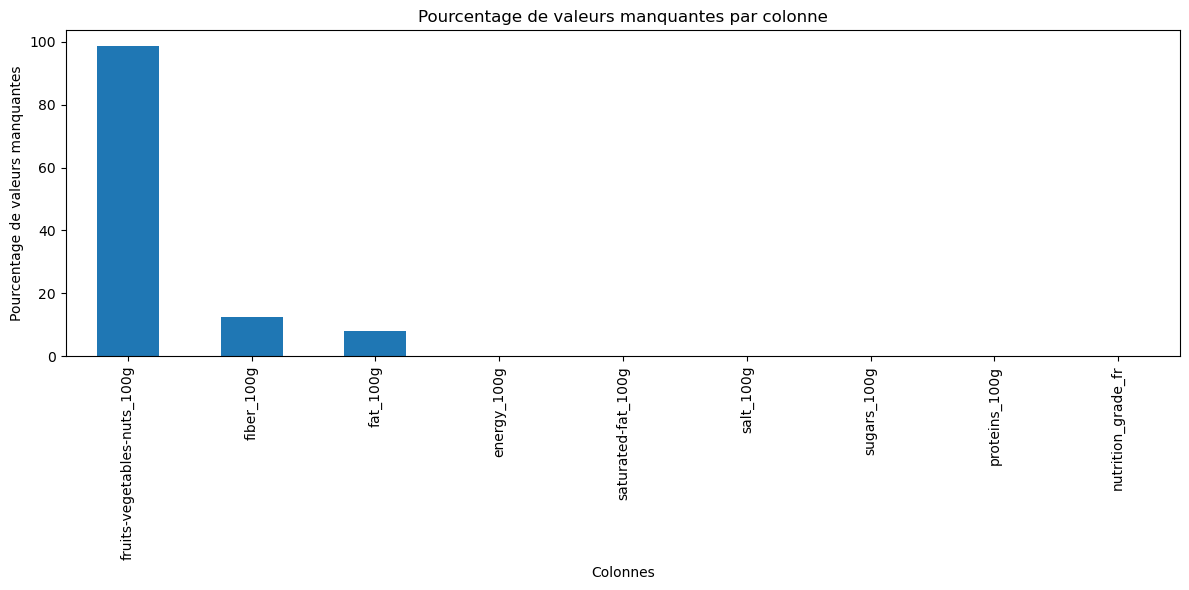

fruits-vegetables-nuts_100g   98.73
fiber_100g                    12.40
fat_100g                       7.90
energy_100g                    0.09
saturated-fat_100g             0.09
salt_100g                      0.09
sugars_100g                    0.09
proteins_100g                  0.09
nutrition_grade_fr             0.00
dtype: float64


In [11]:
missing_percentages = (XClean.isnull().mean() * 100).sort_values(ascending=False)
plt.figure(figsize=(12, 6))
missing_percentages.plot(kind='bar')
plt.title('Pourcentage de valeurs manquantes par colonne')
plt.xlabel('Colonnes')
plt.ylabel('Pourcentage de valeurs manquantes')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

print(missing_percentages)

In [12]:
def impute_missing_values(data):
    dataImputed = data.copy()
    
    numericColumns = data.select_dtypes(include=[np.number]).columns
    for col in numericColumns:
        if col != "fiber_100g" and col != "proteins_100g" and col != "fruits-vegetables-nuts_100g":
            dataImputed[col] = dataImputed[col].fillna(dataImputed[col].median())
        else:
            dataImputed[col] = dataImputed[col].fillna(0)
            
    missing_percentages = (dataImputed.isnull().mean() * 100).sort_values(ascending=False)
    print(missing_percentages)
    return dataImputed

energy_100g                   0.00
fat_100g                      0.00
saturated-fat_100g            0.00
sugars_100g                   0.00
salt_100g                     0.00
fiber_100g                    0.00
proteins_100g                 0.00
fruits-vegetables-nuts_100g   0.00
nutrition_grade_fr            0.00
dtype: float64


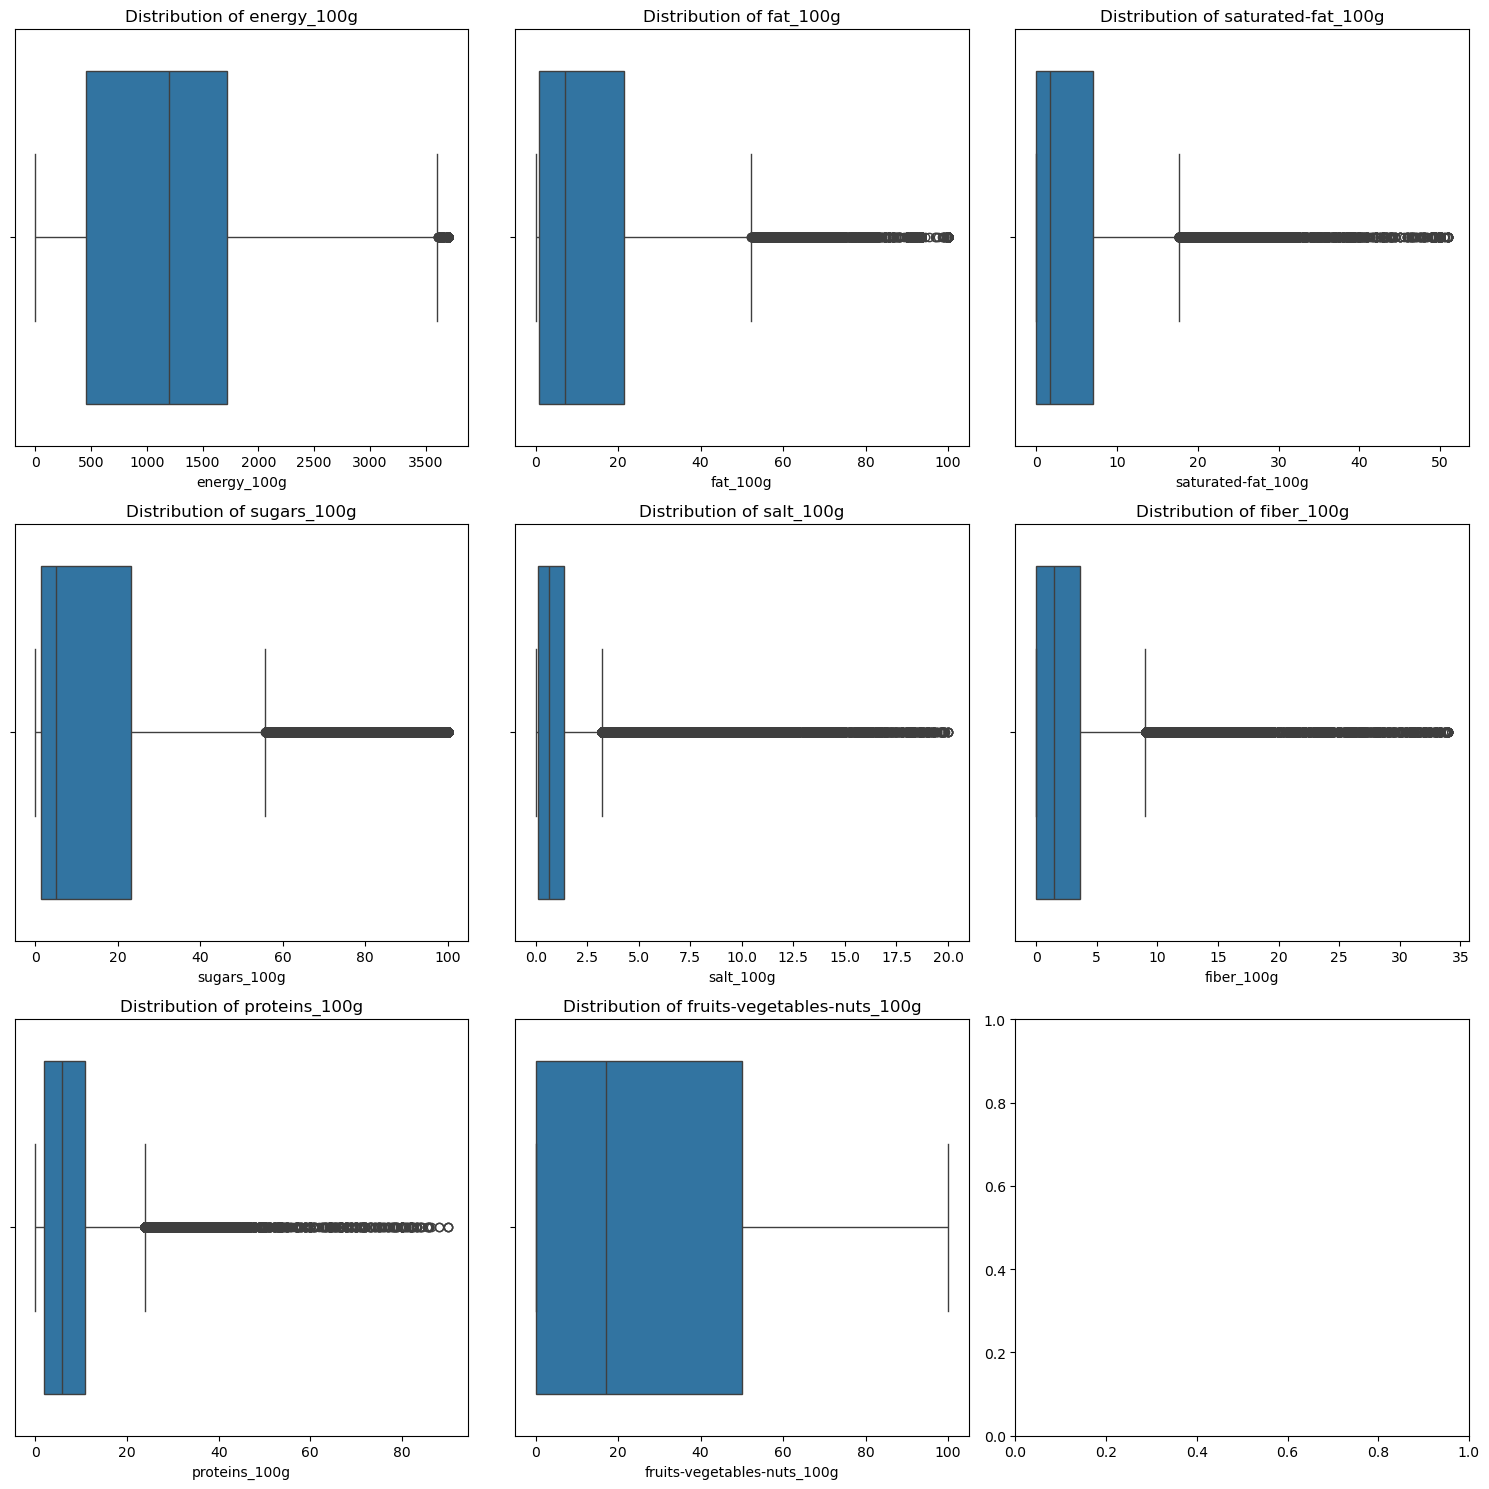

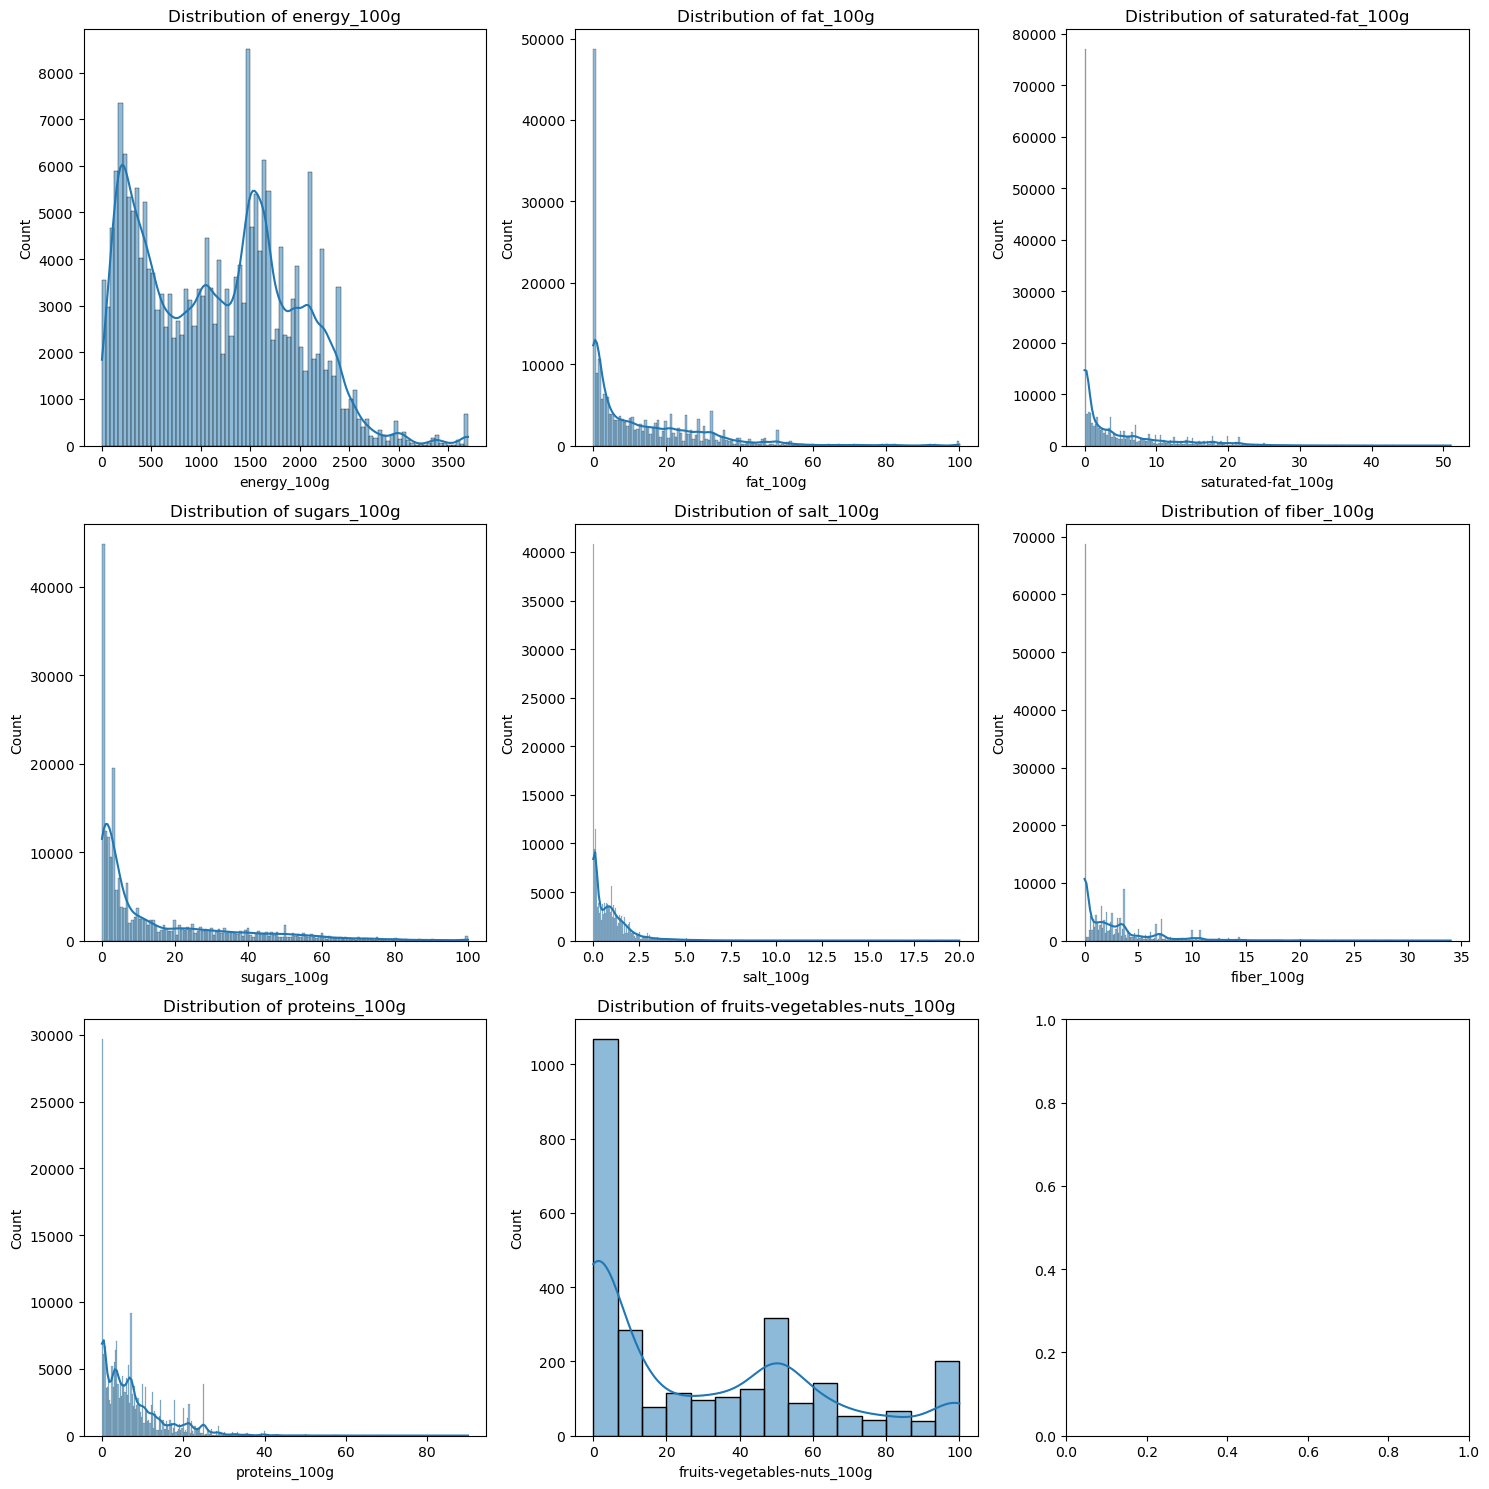

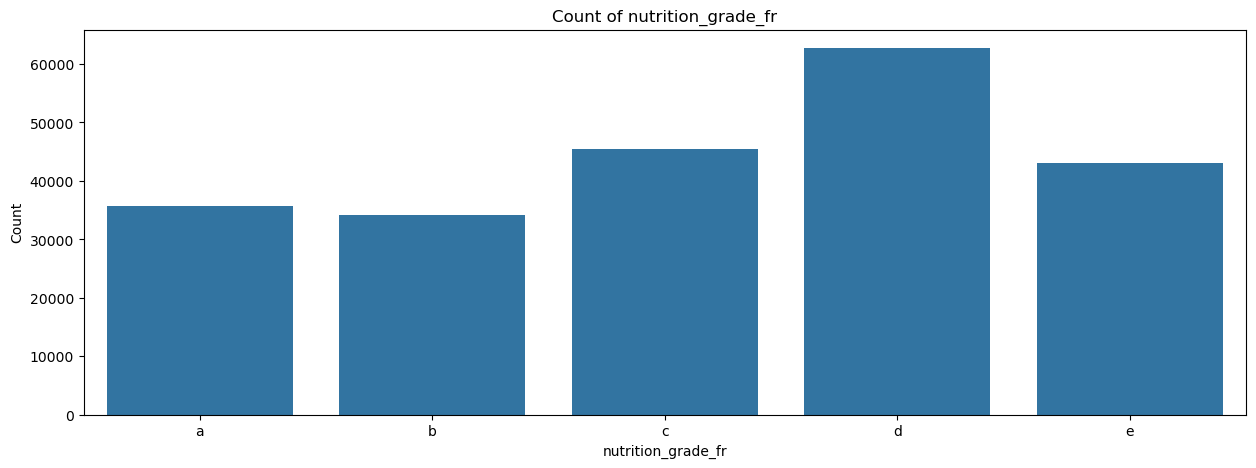

In [13]:
XImputed = impute_missing_values(XClean)
plotBoxplots(XClean, numericColumns)
plotHistograms(XClean, numericColumns)
plotBarplots(XClean, qualitativeColumns)

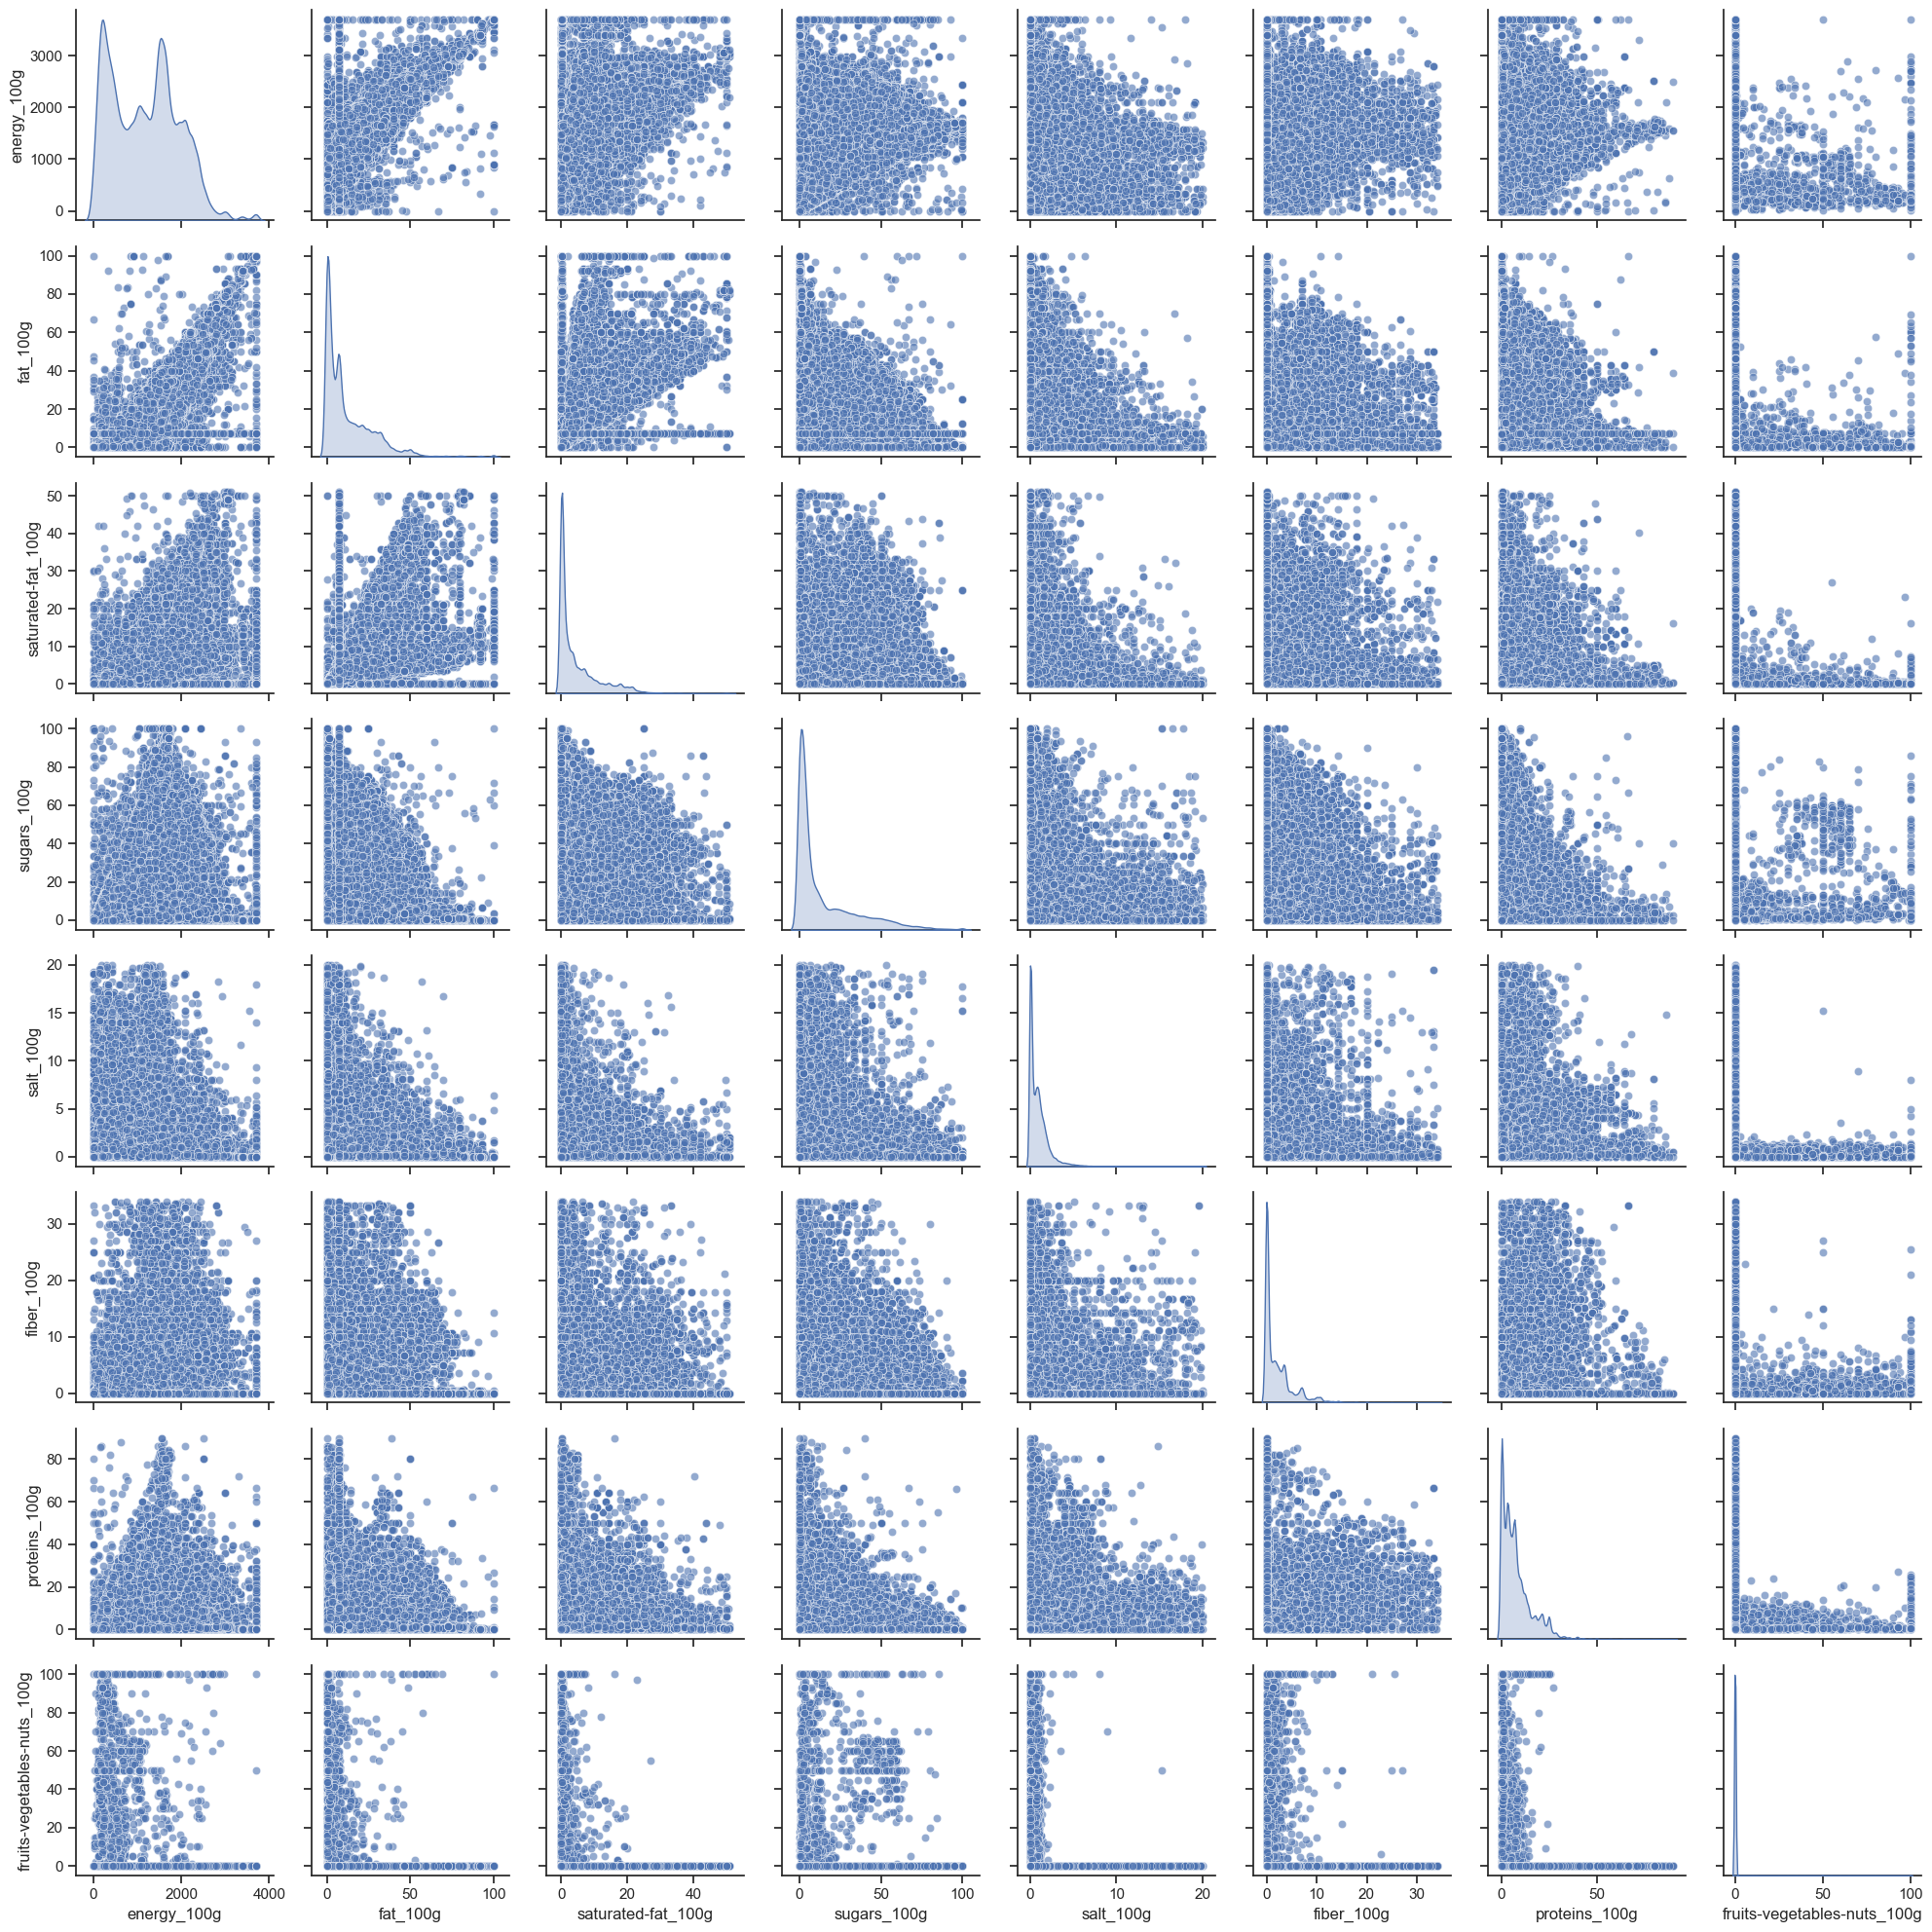

In [14]:
sns.set_theme(style="ticks")
sns.pairplot(XImputed[numericColumns], diag_kind="kde", markers="o", plot_kws={'alpha': 0.6})
plt.tight_layout()
plt.show()


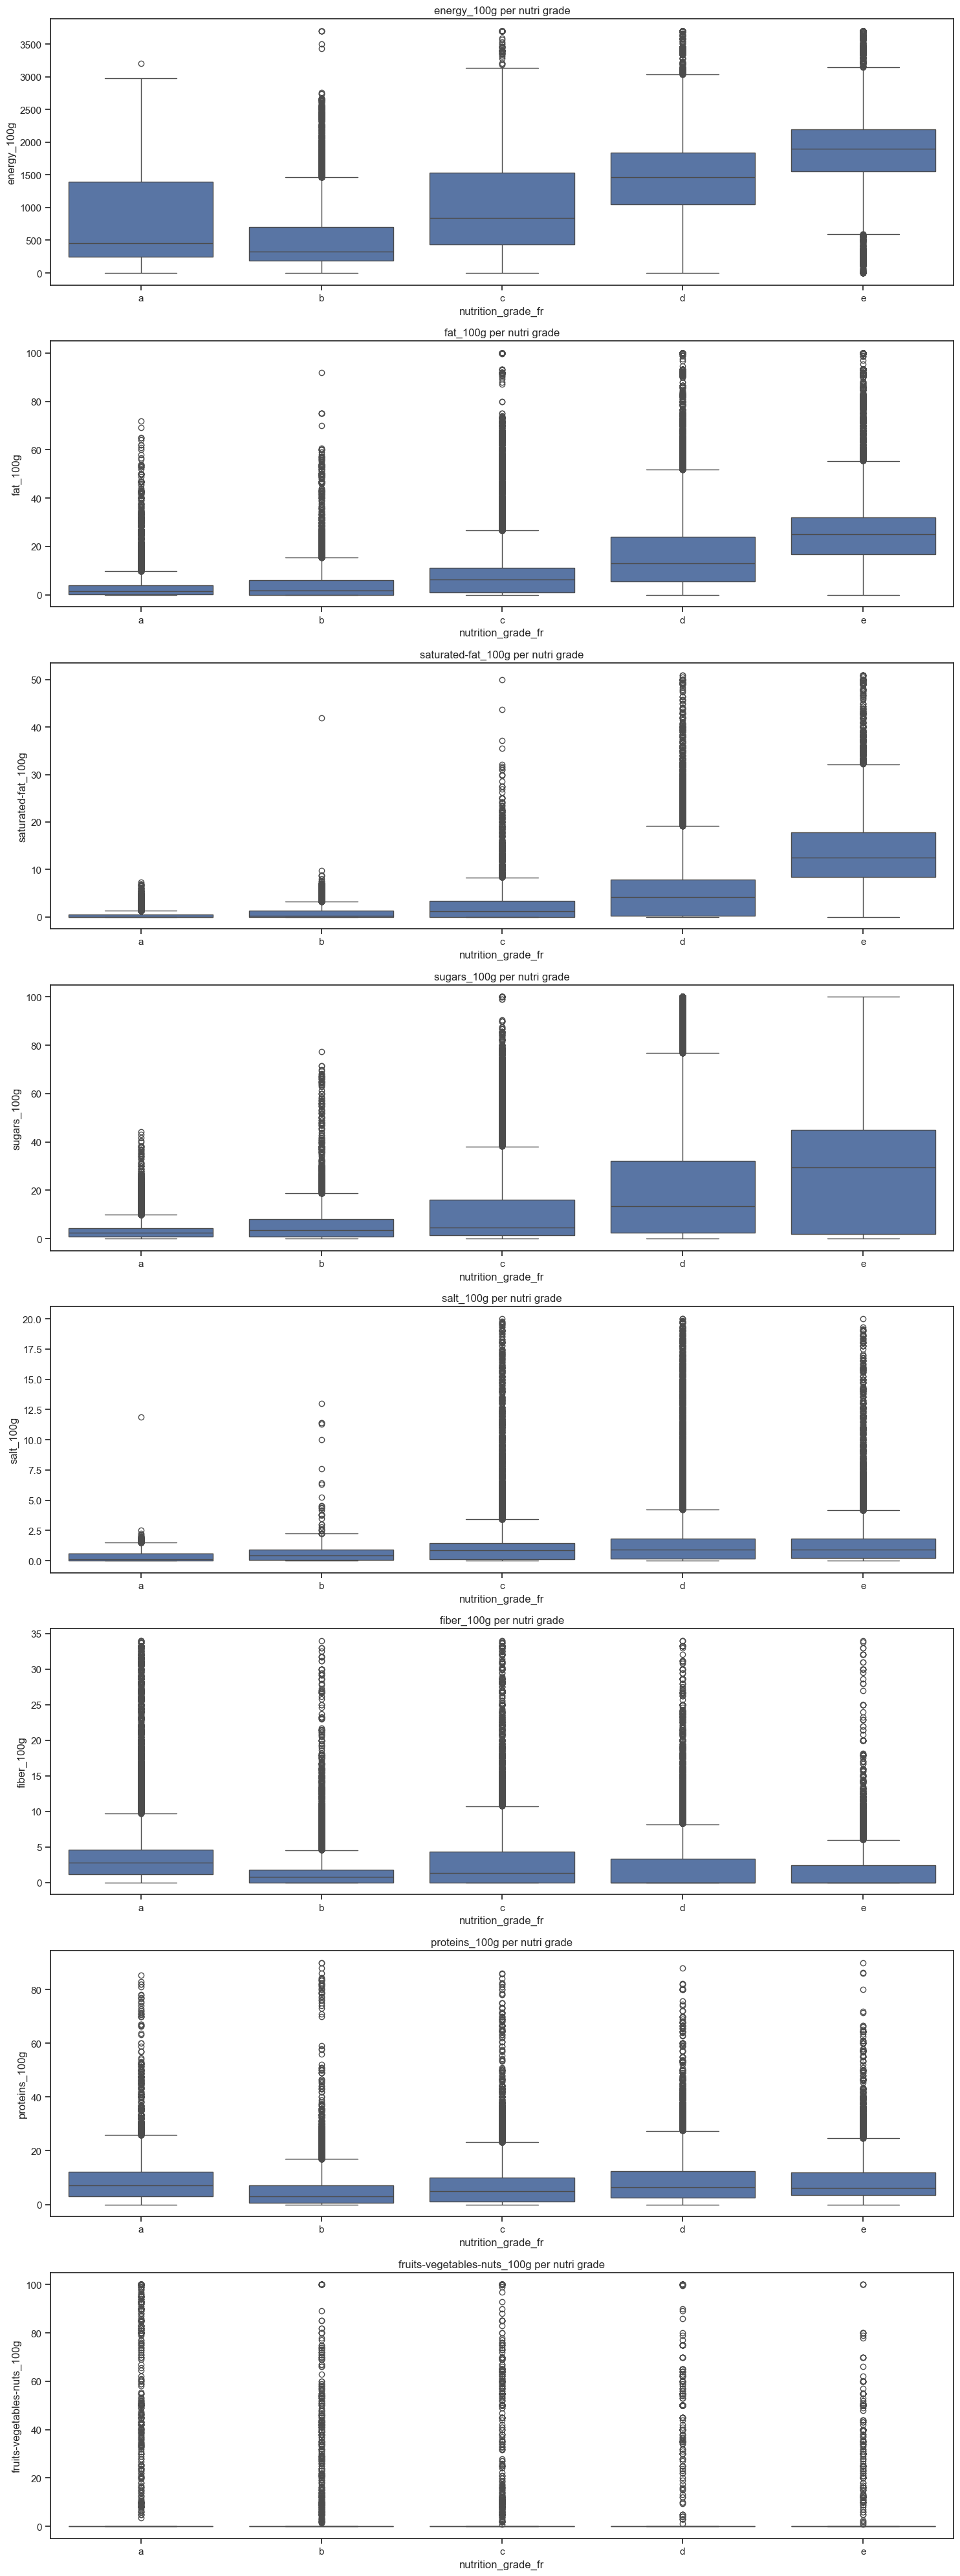

In [15]:

def createBoxplotSubplot(x, ax, var, data, y, order):
    sns.boxplot(x=x, y=var, data=pd.concat([data, y], axis=1), ax=ax, order=order)
    ax.set_title(f'{var} per nutri grade')

def multiBoxPlots(x, data, y, numericColumns):
    numCols = len(numericColumns)
    data = data.drop(x, axis=1)
    fig, axes = plt.subplots(numCols, 1, figsize=(15, 40))
    order = ['a', 'b', 'c', 'd', 'e']
    list(map(createBoxplotSubplot, [x] * numCols, axes, numericColumns, [data] * numCols, [y] * numCols, [order] * numCols))
    plt.tight_layout()
    plt.show()

multiBoxPlots('nutrition_grade_fr', XImputed, y, numericColumns)

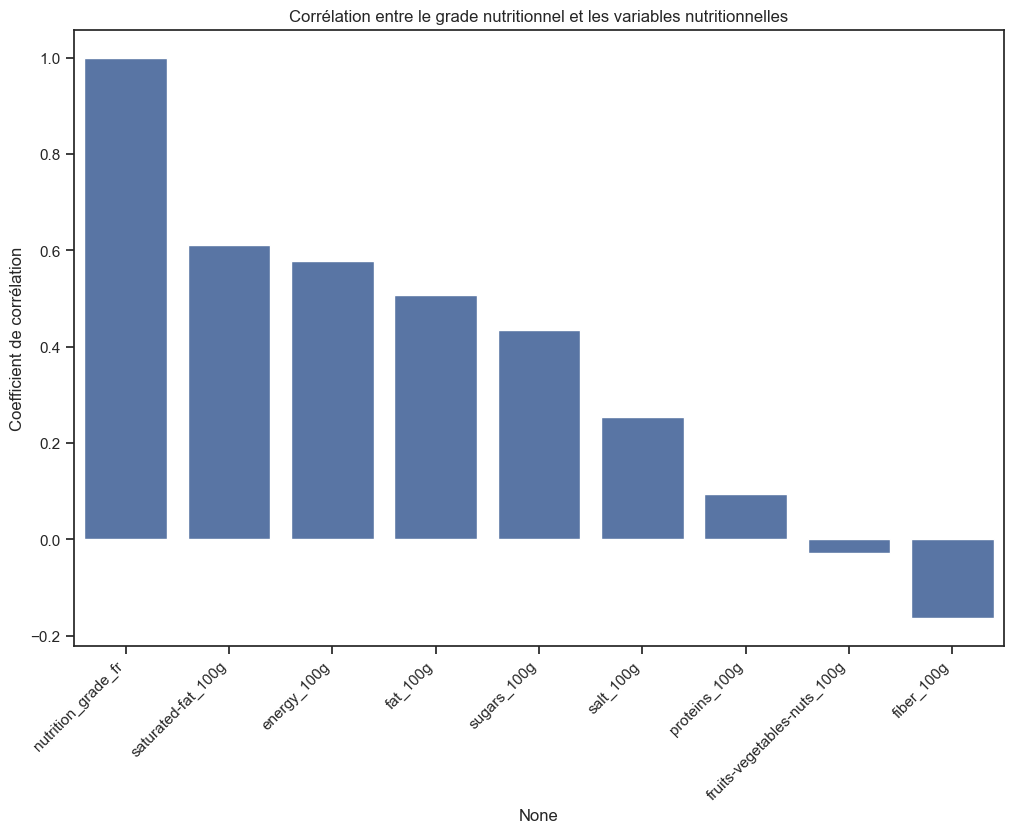

In [16]:
gradeMapping = {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5}
yNumeric = y.map(gradeMapping)
dataCombined = pd.concat([XImputed[numericColumns], yNumeric], axis=1)
correlations = dataCombined[numericColumns + [yNumeric.name]].corr()[yNumeric.name].sort_values(ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(x=correlations.index, y=correlations.values)
plt.title('Corrélation entre le grade nutritionnel et les variables nutritionnelles')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Coefficient de corrélation')
plt.show()

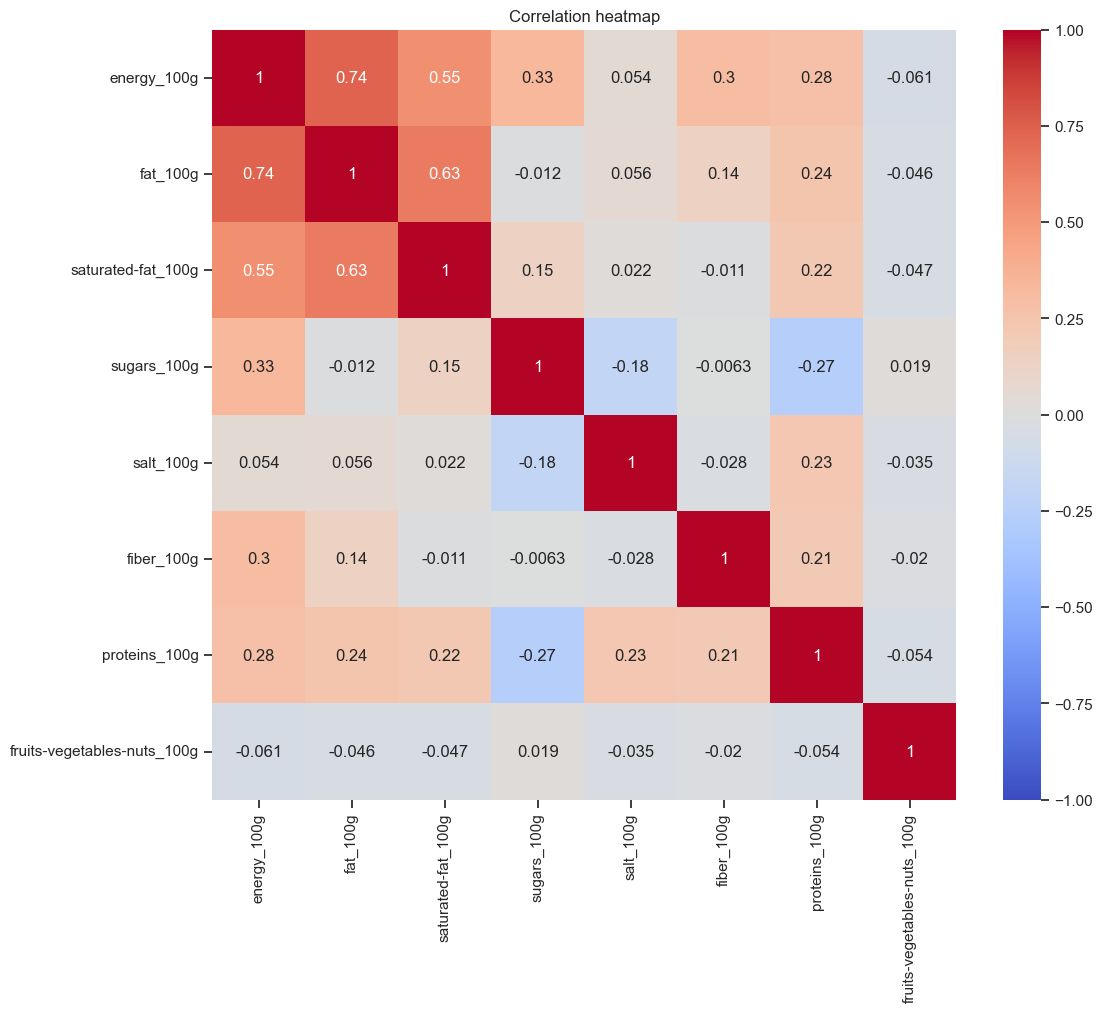

In [21]:
plt.figure(figsize=(12, 10))
sns.heatmap(dataCombined[numericColumns].corr(), 
            annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation heatmap')
plt.show()

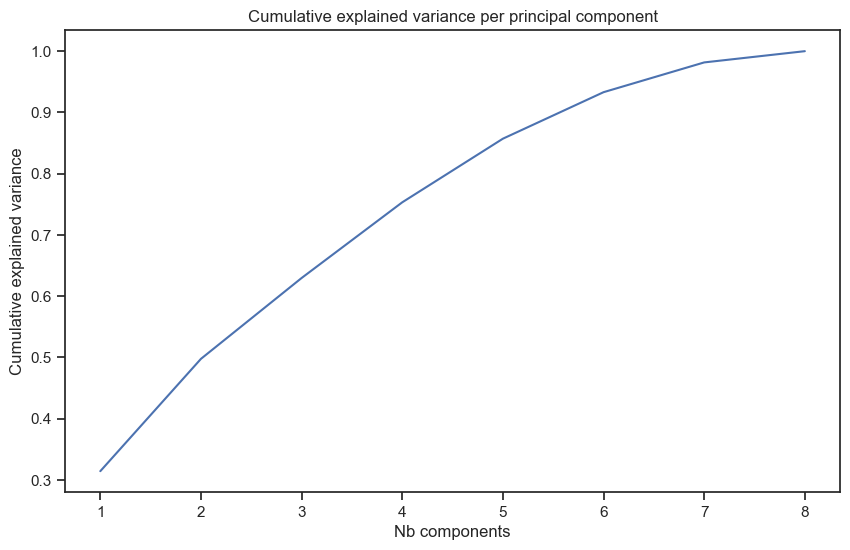

In [22]:
if 'nutrition-score-uk_100g' in numericColumns:
	numericColumns.remove('nutrition-score-uk_100g')
if 'sodium_100g' in numericColumns:
	numericColumns.remove('sodium_100g')
scaler = StandardScaler()
XScaled = scaler.fit_transform(XImputed[numericColumns])

pca = PCA()
XPca = pca.fit_transform(XScaled)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Nb components')
plt.ylabel('Cumulative explained variance')
plt.title('Cumulative explained variance per principal component')
plt.show()

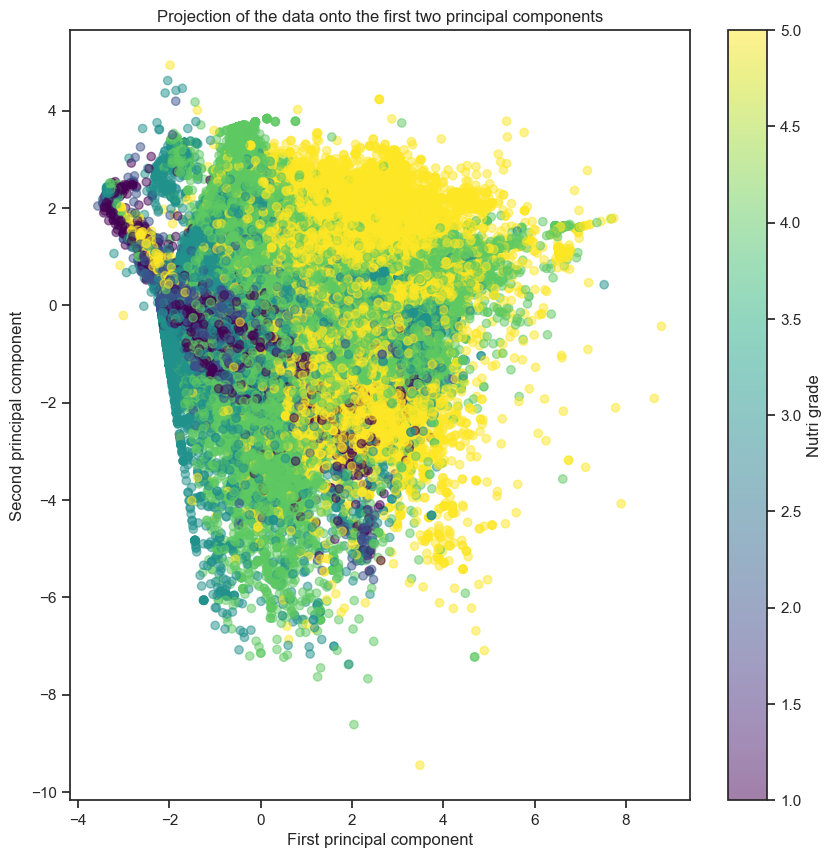

In [26]:
plt.figure(figsize=(10, 10))
plt.scatter(XPca[:, 0], XPca[:, 1], c=yNumeric, cmap='viridis', alpha=0.5)
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('Projection of the data onto the first two principal components')
plt.colorbar(label='Nutri grade')
plt.show()

In [20]:
for var in numericColumns:
    if var in XImputed.columns:
        groups = [group for _, group in XImputed[var].groupby(y)]
        f_value, p_value = stats.f_oneway(*groups)
        print(f"ANOVA for {var}:")
        print(f"F-value: {f_value}")
        print(f"p-value: {p_value}")
        print("\n")

ANOVA for energy_100g:
F-value: 33699.55879818521
p-value: 0.0


ANOVA for fat_100g:
F-value: 20852.853979384185
p-value: 0.0


ANOVA for saturated-fat_100g:
F-value: 47942.9991069228
p-value: 0.0


ANOVA for sugars_100g:
F-value: 13654.893877980721
p-value: 0.0


ANOVA for salt_100g:
F-value: 4309.141399346956
p-value: 0.0


ANOVA for fiber_100g:
F-value: 3441.276734068819
p-value: 0.0


ANOVA for proteins_100g:
F-value: 1687.8251590174298
p-value: 0.0


ANOVA for fruits-vegetables-nuts_100g:
F-value: 64.18461033959098
p-value: 2.4752247711734483e-54




Les résultats suggèrent que la variable nutrition-score-fr_100g est statistiquement significative pour prédire les niveaux de différentes variables nutritionnelles. Cela peut être utile pour comprendre comment les différentes classes de nutrition-score-fr_100g sont associées à des profils nutritionnels spécifiques dans votre ensemble de données.
nutrition-score-fr_100g avec les categorie des aliment peuvent aider a donner le nutrition_grade_fr